### Phase 4 Project
This project was a collaboration between<br>
* Benito Ywani
* Patrick Arnold
* Ahmad Samiee

# Project Overview
In this project we measured text content sentiment in Twitter for two technology firms.  Using natural langguage processing (NLP) methods, we generated models to make predictiions for ternary (negative, neutral and positive) classification output.

# Technical Summary
Our best model for Twitter sentiment prediction was Support Vector Classification which gave an overal accuracy of about 67%. The model under-predicted for all three classifications relative to actual for both firms.  It missed predicting correctly negative sentiment the most followed by positive and then neutral.  This may be because the dataset contained the fewest negative sentiment tweets. There were a moderate number of positive tweets and the most were neutral tweets. However, our model was able to correctly predict the overall trend for classification ratios where tweets with neutral sentiment had the highest ratio followed by positive and then negative. In addition, our model was able to correctly predict which of the two firms had a higher positive sentiment (this was also the case for neutral and negative sentiments).

# Business Problem
Our stakeholder an equity investment firm is considering to purchase equity in a technology compnay and they have narrowed down their selection between two compnaies.  As an additional analysis tool they like to take look at (potential customer) sentiment toward these two final selections. Therefore, they want a machine learning model that can predict sentiment in social media paltform like Twitter and also want to know how acurrately it can predict sentiment.  

## Master Dataset
The data comes from CrowdFlower via [data.world](https://data.world/crowdflower/brands-and-product-emotions) which are tweets from Twitter collected during 2011 at South by Southwest Conference. It consists of about 9000 tweets and the tweets are labelled as negative, neutral or positive. 

## EDA and Feature Engineering
Created a column to identify whether the tweet was about Apple, Google or neither. Duplicated tweets, tweets for which there is no sentiment label and tweets that were neither about Apple or Google were dropped. Created another column to convert text sentiment into a numerical where 0 is for negative, 1 for neutral and 2 for positive sentiment. The cleaned data was then split into apple and google dataframes. These were then split into train (60% of data) and test (40%) dataframes where the three classification ratios for sentiment were split proportionally.  The trained datasets for apple and google were combined into a single dataframe to be used for model training. The tweet text was then processed for natural language processing(NLP) as described in nlp_doc_preparer function.

In [1]:
# Load all the libraries

import pandas as pd
import numpy as np
import string
import re
import time

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score,precision_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import plot_confusion_matrix
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE 

from nltk import word_tokenize
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras import metrics

%matplotlib inline


In [2]:
# Read file
filename = 'data/judge-1377884607_tweet_product_company.csv'

sentiments_df = pd.read_csv(filename, encoding= 'unicode_escape') 


In [3]:
# Data overview
sentiments_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [6]:
# Randomly check tweet text for a couple of rows

pd.set_option('display.max_colwidth', None)
indexes = np.random.randint(0,len(sentiments_df),6)
sentiments_df['tweet_text'].loc[indexes]


2998    It is never more apparent than at #sxsw how nice it would be if apple made stuff w/ removable batteries. #alwayshavingtoplugin #gsdm
77                                                                                                           I worship @mention {link} #SXSW
1885                                                                                           Win an iPad at SXSW via @mention #sxsw {link}
2182                                                                     Austinjs autocorrects to Sisyphus on the iPhone. Just sayin'. #sxsw
8237            #sxsw Just got a Samsung Focus (windows 7) phone at the android dev meetup. We're excited to try it out and build something.
1770                                                         #SXSW 2011: Novelty of iPad news apps fades fast among digital delegates {link}
Name: tweet_text, dtype: object

In [7]:
# Check number of records, data types and which columns have nan

sentiments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [8]:
# Check values for column 'emotion_in_tweet_is_directed_at'

sentiments_df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [9]:
# Confirm number of NaN in column 'emotion_in_tweet_is_directed_at'

sentiments_df['emotion_in_tweet_is_directed_at'].isna().sum()

5802

In [10]:
# Check values for column 'is_there_an_emotion_directed_at_a_brand_or_product'

sentiments_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [11]:

def find_company_name(text,emotion_at):
    
    '''
    Go through text ('tweet_text' column) and determine whether it is about apple or google and
    return either 'apple' or 'google' according to search.
    If cannot tell company id from text, check emotion_at ('emotion_in_tweet_is_directed_at'
    column) for comapy id. If cannot find company id return 'cannot tell'.
    '''
    
    revised_emotion_at = str(emotion_at).lower()
    
    
    revised_text = str(text).lower()
    
    apple = ['apple','iphone','ipad']
    google = ['google','android']
    
    apple_count = 0
    google_count = 0
    
    for a in apple:
        apple_count += sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(a), revised_text))
        
    for g in google:
        google_count += sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(g), revised_text))
    

    if apple_count > google_count:
        return 'apple'
    elif google_count > apple_count:
        return 'google'
    elif revised_emotion_at != 'nan' and revised_emotion_at != 'default':
        for idx, item in enumerate(revised_emotion_at.split()):
            if item in apple:
                return 'apple'
            elif item in google:
                return 'google'
            else:
                if idx == len(revised_emotion_at.split()): 
                    return 'cannot tell'
    else:
        return 'cannot tell'

In [12]:
# Create a new column called 'company_name' and find whether the tweet is about apple,
# google or cannot tell using function find_company_name
 
sentiments_df['company_name'] = sentiments_df.apply(
    lambda s: find_company_name(s['tweet_text'],s['emotion_in_tweet_is_directed_at']),axis=1) 

sentiments_df['company_name'].value_counts()


apple          5331
google         2814
cannot tell     948
Name: company_name, dtype: int64

In [13]:
# Tweets for which cannot tell whether comment directed to apple or google the
# sentiment is mostly neutral (over 95%)

cannot_tell = sentiments_df[sentiments_df['company_name'] == 'cannot tell']
cannot_tell['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    911
Positive emotion                       23
I can't tell                           10
Negative emotion                        4
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [14]:
# Drop any row where 'tweet_text' is nan
sentiments_df.drop(sentiments_df[sentiments_df['tweet_text'].isna()].index,inplace=True)

# Drop any row where 'is_there_an_emotion_directed_at_a_brand_or_product' says 'I can't tell'
column_name = 'is_there_an_emotion_directed_at_a_brand_or_product'
match = 'I can\'t tell'
sentiments_df.drop(sentiments_df[sentiments_df[column_name] == match].index, inplace=True)


# Drop any rows where column 'company_name' says 'cannot tell'
sentiments_df.drop(sentiments_df[sentiments_df['company_name'] == 'cannot tell'].index,
                  inplace=True)

# Drop any duplicated rows
sentiments_df.drop(sentiments_df[sentiments_df.duplicated()].index,inplace=True)

sentiments_df['company_name'].value_counts()

apple     5231
google    2748
Name: company_name, dtype: int64

In [15]:
# Create a function that returns 0 for negative sentiment, 1 for neutral sentiment
# and 2 for positive sentiment

def convert_emotion_tonumber(emotion):
    if emotion == 'Negative emotion':
        return 0
    elif emotion == 'Positive emotion':
        return 2
    else:
        return 1  # for neutral emotion

In [16]:
# Create a column called 'sentiment' and pass value from 
# 'is_there_an_emotion_directed_at_a_brand_or_product' to function convert_emotion_tonumber.

sentiments_df['sentiment'] = sentiments_df[
    'is_there_an_emotion_directed_at_a_brand_or_product'].map(
    lambda s: convert_emotion_tonumber(s))

sentiments_df['sentiment'].value_counts(normalize=True)

1    0.559845
2    0.369345
0    0.070811
Name: sentiment, dtype: float64

In [17]:
sentiments_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7979 entries, 0 to 9092
Data columns (total 5 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          7979 non-null   object
 1   emotion_in_tweet_is_directed_at                     3273 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  7979 non-null   object
 3   company_name                                        7979 non-null   object
 4   sentiment                                           7979 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 374.0+ KB


In [18]:
# Create an intermediate dataframe that only contains columns 'tweet_text','company_name'
# sentiment

sentiments2_df = sentiments_df[['tweet_text','company_name','sentiment']].copy()


In [19]:
sentiments2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7979 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tweet_text    7979 non-null   object
 1   company_name  7979 non-null   object
 2   sentiment     7979 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 249.3+ KB


In [20]:
# Determine approximate total number of unique words in sentiments['tweet_text']

tweet_words = sentiments_df['tweet_text'].map(word_tokenize).values
total_vocabulary = set(word for tweet in tweet_words for word in tweet)
print (f'Total number of unique words in tweet_words: {len(total_vocabulary)}')


Total number of unique words in tweet_words: 12131


In [21]:
# Split sentiments2_df into two data frames where apple_df contains all tweets about apple
# google_df contains all tweets about google

apple_df = sentiments2_df[sentiments2_df['company_name'] == 'apple'].copy()
google_df = sentiments2_df[sentiments2_df['company_name'] == 'google'].copy()


In [22]:
apple_df['sentiment'].value_counts(normalize=True)

1    0.516536
2    0.404512
0    0.078952
Name: sentiment, dtype: float64

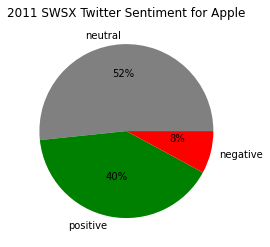

In [23]:
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.0f}%\n".format(pct, absolute)

a_size = list(apple_df['sentiment'].value_counts())
a_labels = ['neutral','positive','negative']
fig,axs = plt.subplots()
axs.pie(a_size,labels=a_labels,autopct=lambda pct: func(pct,a_size),colors=['grey','green','red']);
axs.set_title('2011 SWSX Twitter Sentiment for Apple');
fig.savefig('apple_sentiment')

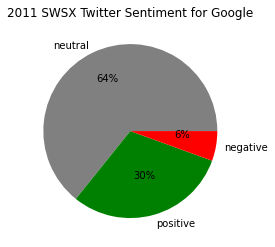

In [24]:
g_size = list(google_df['sentiment'].value_counts())
g_labels = ['neutral','positive','negative']
fig,axs = plt.subplots()
axs.pie(g_size,labels=g_labels,autopct=lambda pct: func(pct,g_size),colors=['grey','green','red']);
axs.set_title('2011 SWSX Twitter Sentiment for Google');
fig.savefig('google_sentiment');

In [25]:
def get_wordnet_pos(tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [26]:
def nlp_doc_preparer(doc,array='no'):
    '''
     - Customize nltk stop_words to include all punction marks, numbers and acronym 'sxsw'
     - Split text into words containing letters
     - Make all letters lower case
     - Use pos_tag to mark up the words for a particular part of a speech
     - Use get_wordnet_pos to convert pos_tag to wordnet_pos
     - Convert word to root word with WordNetLemmatizer
     - Return processed document as a string of words
    '''
    
    custom_sw = stopwords.words('english')
    punctuation = [c for c in list(string.punctuation)]
    numbers = [n for n in range(0,10)]
    custom_sw.extend(punctuation+numbers)
    custom_sw.extend(['sxsw','SXSW','Sxsw'])

    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in custom_sw]
    
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    
    if array == 'no':
        return ' '.join(doc)  
    else:
        return doc


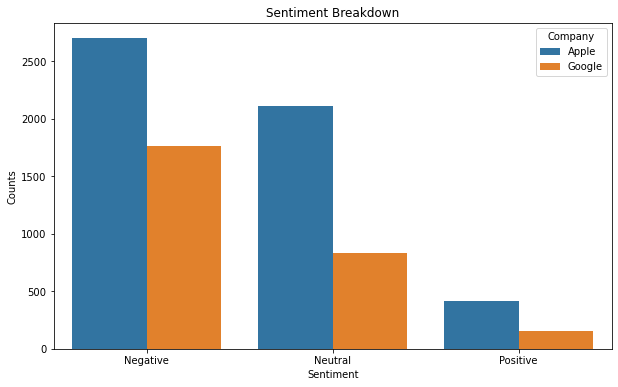

In [28]:
# Show sentiment breakdown for Apple and Google 

apple_sentiment = apple_df['sentiment'].value_counts()
google_sentiment = google_df['sentiment'].value_counts()

sentiments = pd.DataFrame({'Sentiment': ['Negative','Neutral','Positive',
                                         'Negative','Neutral','Positive'],
                   'Counts': (list(apple_sentiment) + list(google_sentiment)),
                   'Company': (['Apple']*3 + ['Google']*3)})

fig,ax = plt.subplots(figsize=(10,6))
sentiment_plot = sns.barplot(x='Sentiment', y='Counts', hue='Company', data=sentiments);
sentiment_plot.set_title('Sentiment Breakdown');

In [29]:
# Create data frames for each of the three sentiments for each company

apple_neg_tw = apple_df[apple_df['sentiment'] == 0]
apple_neu_tw = apple_df[apple_df['sentiment'] == 1]
apple_pos_tw = apple_df[apple_df['sentiment'] == 2]

google_neg_tw = google_df[google_df['sentiment'] == 0]
google_neu_tw = google_df[google_df['sentiment'] == 1]
google_pos_tw = google_df[google_df['sentiment'] == 2]

app_neg_tw = [nlp_doc_preparer(tweet,'yes') for tweet in apple_neg_tw['tweet_text']]
app_neu_tw = [nlp_doc_preparer(tweet,'yes') for tweet in apple_neu_tw['tweet_text']]
app_pos_tw = [nlp_doc_preparer(tweet,'yes') for tweet in apple_pos_tw['tweet_text']]

goo_neg_tw = [nlp_doc_preparer(tweet,'yes') for tweet in google_neg_tw['tweet_text']]
goo_neu_tw = [nlp_doc_preparer(tweet,'yes') for tweet in google_neu_tw['tweet_text']]
goo_pos_tw = [nlp_doc_preparer(tweet,'yes') for tweet in google_pos_tw['tweet_text']]

In [30]:
# A function to flatten array of arrays and return the flattened array

def flatten_list(list_of_lists):
    return [word for line in list_of_lists for word in line]

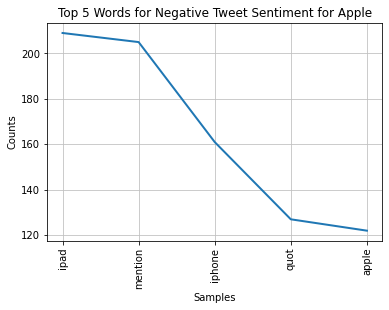

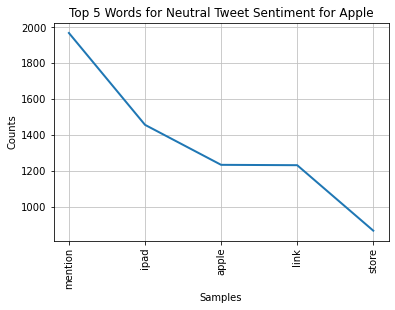

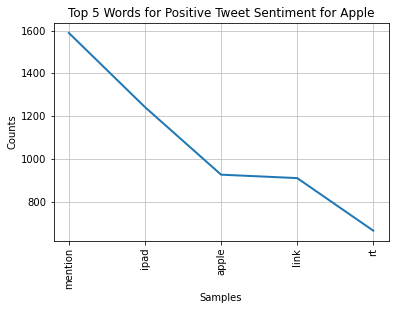

In [32]:
# Show top 5 frequenly occuring words for Apple for each sentiment

app_neg_tw_f = flatten_list(app_neg_tw)
app_neu_tw_f = flatten_list(app_neu_tw)
app_pos_tw_f = flatten_list(app_pos_tw)

apple_tweets = [['Top 5 Words for Negative Tweet Sentiment for Apple',app_neg_tw_f],
                ['Top 5 Words for Neutral Tweet Sentiment for Apple',app_neu_tw_f],
                ['Top 5 Words for Positive Tweet Sentiment for Apple',app_pos_tw_f]]

fig, axs = plt.subplots()
for i in range(3):
    t = FreqDist(apple_tweets[i][1])
    t.plot(5,title=apple_tweets[i][0]);

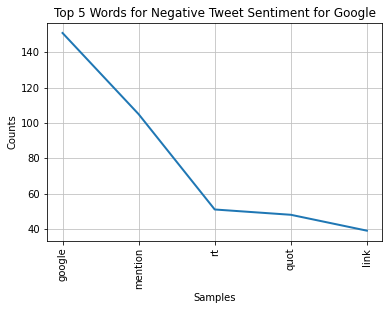

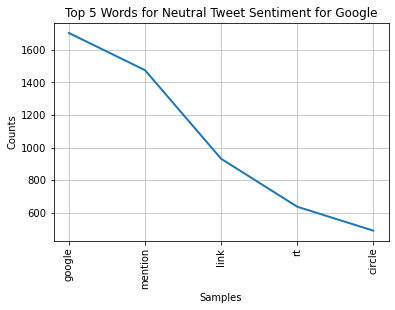

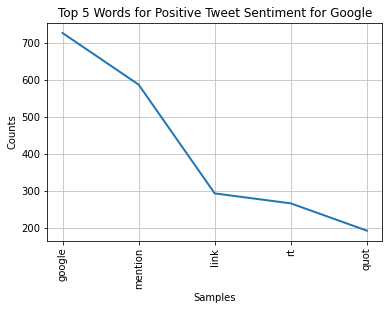

In [33]:
# Show top 5 frequenly occuring words for Google for each sentiment

goo_neg_tw_f = flatten_list(goo_neg_tw)
goo_neu_tw_f = flatten_list(goo_neu_tw)
goo_pos_tw_f = flatten_list(goo_pos_tw)

apple_tweets = [['Top 5 Words for Negative Tweet Sentiment for Google',goo_neg_tw_f],
                ['Top 5 Words for Neutral Tweet Sentiment for Google',goo_neu_tw_f],
                ['Top 5 Words for Positive Tweet Sentiment for Google',goo_pos_tw_f]]

fig, axs = plt.subplots()
for i in range(3):
    t = FreqDist(apple_tweets[i][1])
    t.plot(5,title=apple_tweets[i][0]);

In [34]:
# Split apple_df and google_df into train and test samples using train_test_split

X_train_app, X_test_app, y_train_app, y_test_app = train_test_split(apple_df['tweet_text'],
                                                apple_df['sentiment'],test_size = 0.4, 
                                                stratify = apple_df['sentiment'],
                                                random_state = 6781)

X_train_goo, X_test_goo, y_train_goo, y_test_goo = train_test_split(google_df['tweet_text'],
                                                google_df['sentiment'],test_size = 0.4, 
                                                stratify = google_df['sentiment'],
                                                random_state = 6782)


In [35]:
a = len(X_train_app)
g = len(X_train_goo)
a+g

4786

In [36]:
# Combined X_train_app and X_train_goo into single series 
# and y_train_app and y_train_goo 

X_train_combined = pd.concat([X_train_app,X_train_goo])
y_train_combined = pd.concat([y_train_app,y_train_goo])



In [37]:
len(X_train_combined) == len(y_train_combined)

True

In [38]:
sum(X_train_combined.index == y_train_combined.index)

4786

In [39]:
# Process X_train_combined, X_test_app, X_test_goo with nlp_doc_preparer function

X_train_combined_processed = [nlp_doc_preparer(tweet) for tweet in X_train_combined]

X_test_app_processed = [nlp_doc_preparer(tweet) for tweet in X_test_app]
X_test_goo_processed = [nlp_doc_preparer(tweet) for tweet in X_test_goo]


In [40]:

def display_cross_validation_results(cross_val,model_name):
    '''
    Incoporate cross validation results into a pandas dataframe and display validation scores
    '''
    
    cross_val_results = pd.DataFrame(cross_val)
    
    accuracy = cross_val_results['mean_test_accuracy'][0]
    recall = cross_val_results['mean_test_recall'][0]
    precision = cross_val_results['mean_test_precision'][0]
    
    print('Validation','='*60)
    print(f'Validation results for {model_name}:')
    print(f'Accuracy: {accuracy}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}\n')

In [41]:

def display_prediction_results(prediction, actuall, company_name, model_name):
    '''
    Get predictions for X_test samples and display scores
    '''
    
    accuracy = accuracy_score(actuall,prediction)
    recall = recall_score(actuall, prediction, average = 'micro')
    precision = precision_score(actuall, prediction, average = 'micro')

    print('='*60)
    print(f'Predictions for {company_name}: {model_name}')
    print(f'Accuracy: {accuracy}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}\n')


In [118]:
def display_confusion_matrix_v2(actuall_y,predicted_y,model_name,company_name):
    conf_matrix = confusion_matrix(y_true=actuall_y, y_pred=predicted_y)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
    plt.xlabel('Predictions', fontsize=14)
    plt.ylabel('Actuals', fontsize=14)
    plt.title(f'Confusion Matrix for {model_name}: {company_name}', fontsize=18);
    save_image_as = 'confusion_matrix_' + '_'.join(model_name.split()) + ': ' + company_name
    fig.savefig(save_image_as)
    

In [42]:
def display_confusion_matrix(model, X, y,company_name, model_name):
    print(f'Confusion matrix for: {company_name}')
    print(f'Model: {model_name}')
    plot_confusion_matrix(model,X,y)
    print('='*80)
    

## Model Training and Model Prediction
Used CountVectorizer (and to lesser extent TfidfVectorizer) to convert text tweet into matrix of tokens.  The models were trained and validated with the combined train dataframe from apple and google tweets. Used pipes to minimize redundant code an gridsearchcv for model tuning and validation. Model predictions were made with apple and google test dataframes.   

In [115]:
# DummyClassifier
# Use pipes to countVectorize X_train_combined_processed and then train DummyClassifier

start = time.time()

cv_dm_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('dm',DummyClassifier())])

grid_accuracy = make_scorer(accuracy_score)
grid_recall_micro = make_scorer(recall_score, average = 'micro')
grid_precision_micro = make_scorer(precision_score, average = 'micro')

cv_dm_params = {'countvect__input' : ['content'],
                'dm__random_state' : [1234],
                'dm__strategy' : ['prior']}

cv_dm_model_grid = GridSearchCV(estimator = cv_dm_pipe, param_grid = cv_dm_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')

cv_dm_model_grid.fit(X_train_combined_processed,y_train_combined)
end = time.time()
print(f'Training time: {end-start}')
cv_dm_model_grid.best_params_

Training time: 0.4847831726074219


{'countvect__input': 'content',
 'dm__random_state': 1234,
 'dm__strategy': 'prior'}

In [116]:
# Display cross validation results, make prediction for X_test_app and X_test_goo
# diplay results.  Use respective functions.

model_name = 'DummyClassifier with Count Vectorize'

display_cross_validation_results(cv_dm_model_grid.cv_results_,model_name)

y_test_app_hat = cv_dm_model_grid.predict(X_test_app_processed)
y_test_goo_hat = cv_dm_model_grid.predict(X_test_goo_processed)

display_prediction_results(y_test_app_hat, y_test_app,'Apple',model_name)

display_prediction_results(y_test_goo_hat, y_test_goo, 'Google',model_name)


Validation ============================================================
Validation results for DummyClassifier with Count Vectorize:
Accuracy: 0.5599666668848153
Recall: 0.5599666668848153
Precision: 0.5599666668848153

Predictions for Apple: DummyClassifier with Count Vectorize
Accuracy: 0.5164835164835165
Recall: 0.5164835164835165
Precision: 0.5164835164835165

Predictions for Google: DummyClassifier with Count Vectorize
Accuracy: 0.6418181818181818
Recall: 0.6418181818181818
Precision: 0.6418181818181818



Confusion matrix for: Apple
Model: DummyClassifier with Count Vectorize


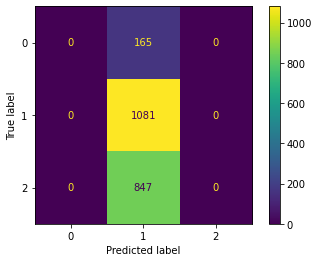

In [121]:
# Diplay confusion matrix for X_test_app

#display_confusion_matrix_v2(y_test_app,y_test_app_hat,model_name,'Apple')
display_confusion_matrix(cv_dm_model_grid, X_test_app_processed,
                         y_test_app, 'Apple',model_name)


Confusion matrix for: Google
Model: DummyClassifier with Count Vectorize


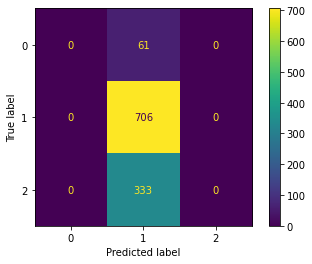

In [122]:
# Diplay confusion matrix for X_test_goo
#display_confusion_matrix_v2(y_test_goo,y_test_goo_hat,model_name,'Google')
display_confusion_matrix(cv_dm_model_grid,X_test_goo_processed,
                         y_test_goo, 'Google',model_name)


In [47]:
# MultinomialNB
# Use pipes to countVectorize X_train_combined_processed and then train MultinomialNB

start = time.time()

cv_mnb_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('mnb', MultinomialNB())])

cv_mnb_params = {'countvect__input' : ['content'],'mnb__alpha' : [1.0]}

cv_mnb_model_grid = GridSearchCV(estimator = cv_mnb_pipe, param_grid = cv_mnb_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')

cv_mnb_model_grid.fit(X_train_combined_processed,y_train_combined)
end = time.time()
print(f'Training time: {end-start}')

Training time: 0.5058467388153076


In [48]:
# Display cross validation results, make prediction for X_test_app and X_test_goo
# diplay results.  Use respective functions.

model_name = 'MultinomialNB with Count Vectorize'

display_cross_validation_results(cv_mnb_model_grid.cv_results_,model_name)

y_test_app_hat2 = cv_mnb_model_grid.predict(X_test_app_processed)
y_test_goo_hat2 = cv_mnb_model_grid.predict(X_test_goo_processed)

display_prediction_results(y_test_app_hat2, y_test_app,'Apple',model_name)

display_prediction_results(y_test_goo_hat2, y_test_goo, 'Google',model_name)


Validation ============================================================
Validation results for MultinomialNB with Count Vectorize:
Accuracy: 0.6276688852385346
Recall: 0.6276688852385346
Precision: 0.6276688852385346

Predictions for Apple: MultinomialNB with Count Vectorize
Accuracy: 0.6086956521739131
Recall: 0.6086956521739131
Precision: 0.6086956521739131

Predictions for Google: MultinomialNB with Count Vectorize
Accuracy: 0.6854545454545454
Recall: 0.6854545454545454
Precision: 0.6854545454545454



Confusion matrix for: Apple
Model: MultinomialNB with Count Vectorize


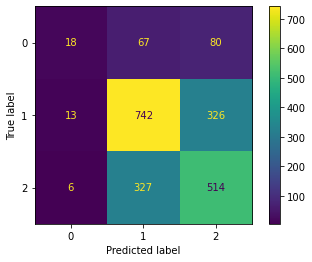

In [49]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(cv_mnb_model_grid, X_test_app_processed,
                         y_test_app, 'Apple',model_name)


Confusion matrix for: Google
Model: MultinomialNB with Count Vectorize


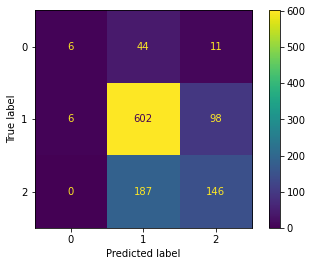

In [50]:
# Diplay confusion matrix for X_test_goo

display_confusion_matrix(cv_mnb_model_grid,X_test_goo_processed,
                         y_test_goo, 'Google',model_name)


In [51]:

# Use pipes to TfidfVectorize X_train_combined_processed and then train MultinomialNB()

start = time.time()

tf_mnb_pipe = Pipeline([('tfvect',TfidfVectorizer()), 
                 ('mnb', MultinomialNB())])

tf_mnb_params = {'tfvect__input' : ['content'],'mnb__alpha' : [1.0]}

tf_mnb_model_grid = GridSearchCV(estimator = tf_mnb_pipe, param_grid = tf_mnb_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')


tf_mnb_model_grid.fit(X_train_combined_processed,y_train_combined)
end = time.time()
print(f'Training time: {end-start}')

Training time: 0.4806020259857178


In [52]:
# Display cross validation results, make prediction for X_test_app and X_test_goo
# diplay results.  Use respective functions.

model_name = 'MultinomialNB with TF-IDF Vectorize'

display_cross_validation_results(tf_mnb_model_grid.cv_results_,model_name)

y_test_app_hat3 = tf_mnb_model_grid.predict(X_test_app_processed)
y_test_goo_hat3 = tf_mnb_model_grid.predict(X_test_goo_processed)

display_prediction_results(y_test_app_hat3, y_test_app,'Apple',model_name)

display_prediction_results(y_test_goo_hat3, y_test_goo, 'Google',model_name)


Validation ============================================================
Validation results for MultinomialNB with TF-IDF Vectorize:
Accuracy: 0.6305925135743002
Recall: 0.6305925135743002
Precision: 0.6305925135743002

Predictions for Apple: MultinomialNB with TF-IDF Vectorize
Accuracy: 0.6077400860009555
Recall: 0.6077400860009555
Precision: 0.6077400860009555

Predictions for Google: MultinomialNB with TF-IDF Vectorize
Accuracy: 0.6863636363636364
Recall: 0.6863636363636364
Precision: 0.6863636363636364



Confusion matrix for: Apple
Model: MultinomialNB with TF-IDF Vectorize


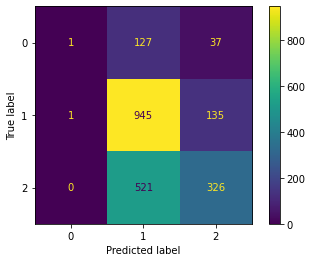

In [53]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(tf_mnb_model_grid, X_test_app_processed,
                         y_test_app, 'Apple',model_name)


Confusion matrix for: Google
Model: MultinomialNB with TF-IDF Vectorize


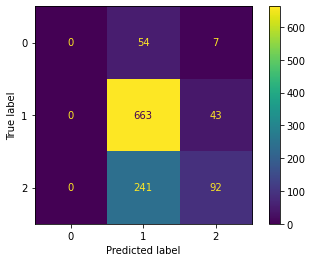

In [54]:
# Diplay confusion matrix for X_test_goo

display_confusion_matrix(tf_mnb_model_grid,X_test_goo_processed,
                         y_test_goo, 'Google',model_name)


In [55]:
# KNeighborsClassifier
# Use pipes to CountVectorize X_train_combined_processed and then train KNeighborsClassifier

start = time.time()

cv_knn_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('knn', KNeighborsClassifier())])

cv_knn_params = {'countvect__input' : ['content'],
                 'knn__n_neighbors' : [7],  # tried 3,7,21
                'knn__weights' : ['distance'], # tried 'uniform
                'knn__leaf_size' : [7]}  #tried 3,15,30,45

cv_knn_model_grid = GridSearchCV(estimator = cv_knn_pipe, param_grid = cv_knn_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')


cv_knn_model_grid.fit(X_train_combined_processed,y_train_combined)
end = time.time()
print(f'Training time: {end-start}')
cv_knn_model_grid.best_params_

Training time: 1.0253260135650635


{'countvect__input': 'content',
 'knn__leaf_size': 7,
 'knn__n_neighbors': 7,
 'knn__weights': 'distance'}

In [56]:
# Display cross validation results, make prediction for X_test_app and X_test_goo
# diplay results.  Use respective functions.

model_name = 'KNeighborsClassifier with Count Vectorize'

display_cross_validation_results(cv_knn_model_grid.cv_results_,model_name)

y_test_app_hat4 = cv_knn_model_grid.predict(X_test_app_processed)
y_test_goo_hat4 = cv_knn_model_grid.predict(X_test_goo_processed)

display_prediction_results(y_test_app_hat4, y_test_app,'Apple',model_name)

display_prediction_results(y_test_goo_hat4, y_test_goo, 'Google',model_name)


Validation ============================================================
Validation results for KNeighborsClassifier with Count Vectorize:
Accuracy: 0.5927709897186537
Recall: 0.5927709897186537
Precision: 0.5927709897186537

Predictions for Apple: KNeighborsClassifier with Count Vectorize
Accuracy: 0.5656951743908266
Recall: 0.5656951743908266
Precision: 0.5656951743908266

Predictions for Google: KNeighborsClassifier with Count Vectorize
Accuracy: 0.6563636363636364
Recall: 0.6563636363636364
Precision: 0.6563636363636364



Confusion matrix for: Apple
Model: KNeighborsClassifier with Count Vectorize


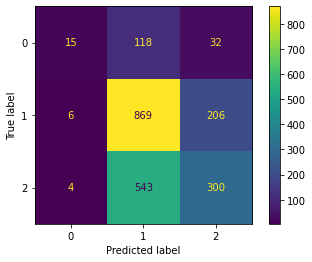

In [57]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(cv_knn_model_grid, X_test_app_processed,
                         y_test_app, 'Apple',model_name)

Confusion matrix for: Google
Model: KNeighborsClassifier with Count Vectorize


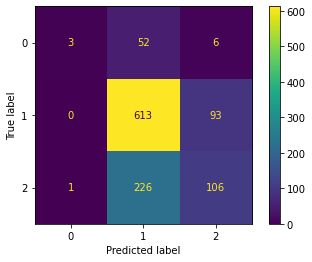

In [58]:
# Diplay confusion matrix for X_test_goo

display_confusion_matrix(cv_knn_model_grid, X_test_goo_processed,
                         y_test_goo, 'Google',model_name)

In [59]:
# Use pipes to TfidfVectorize X_train_combined_processed and then train KNeighborsClassifier

start = time.time()

tf_knn_pipe = Pipeline([('tfvect',TfidfVectorizer()), 
                 ('knn', KNeighborsClassifier())])

tf_knn_params = {'tfvect__input' : ['content'],
                 'knn__n_neighbors' : [7],  # tried 3,7,21
                'knn__weights' : ['distance'], # tried 'uniform
                'knn__leaf_size' : [3]}  #tried 30,45

tf_knn_model_grid = GridSearchCV(estimator = cv_knn_pipe, param_grid = cv_knn_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')


tf_knn_model_grid.fit(X_train_combined_processed,y_train_combined)
end = time.time()
print(f'Training time: {end-start}')
tf_knn_model_grid.best_params_

Training time: 1.0332210063934326


{'countvect__input': 'content',
 'knn__leaf_size': 7,
 'knn__n_neighbors': 7,
 'knn__weights': 'distance'}

In [60]:
# Display cross validation results, make prediction for X_test_app and X_test_goo
# diplay results.  Use respective functions.

model_name = 'KNeighborsClassifier with TF-IDF Vectorize'

display_cross_validation_results(tf_knn_model_grid.cv_results_,model_name)

y_test_app_hat5 = tf_knn_model_grid.predict(X_test_app)
y_test_goo_hat5 = tf_knn_model_grid.predict(X_test_goo)

display_prediction_results(y_test_app_hat5, y_test_app,'Apple',model_name)

display_prediction_results(y_test_goo_hat5, y_test_goo, 'Google',model_name)


Validation ============================================================
Validation results for KNeighborsClassifier with TF-IDF Vectorize:
Accuracy: 0.5927709897186537
Recall: 0.5927709897186537
Precision: 0.5927709897186537

Predictions for Apple: KNeighborsClassifier with TF-IDF Vectorize
Accuracy: 0.5642618251313903
Recall: 0.5642618251313903
Precision: 0.5642618251313903

Predictions for Google: KNeighborsClassifier with TF-IDF Vectorize
Accuracy: 0.6327272727272727
Recall: 0.6327272727272727
Precision: 0.6327272727272727



Confusion matrix for: Apple
Model: KNeighborsClassifier with TF-IDF Vectorize


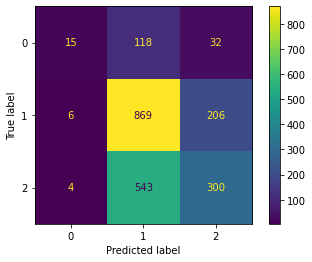

In [61]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(tf_knn_model_grid, X_test_app_processed,
                         y_test_app, 'Apple',model_name)

Confusion matrix for: Google
Model: KNeighborsClassifier with TF-IDF Vectorize


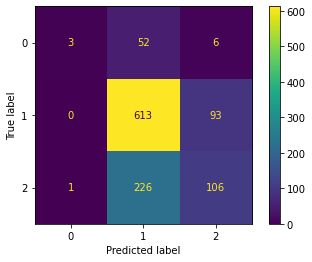

In [62]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(tf_knn_model_grid, X_test_goo_processed,
                         y_test_goo, 'Google',model_name)

In [63]:
# RandomForestClassifier
# Use pipes to CountVectorize X_train_combined_processed and then train RandomForestClassifier

start = time.time()

cv_rf_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('rf', RandomForestClassifier())])

cv_rf_params = {'countvect__input' : ['content'],
                'rf__random_state' : [42],
                'rf__max_depth' : [87],  # tried 3,11,57,121
                'rf__criterion' : ['gini'],  #log_loss gives warning
                'rf__max_features' : [None]} # tried 'sqrt' and 'log2'

cv_rf_model_grid = GridSearchCV(estimator = cv_rf_pipe, param_grid = cv_rf_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')


cv_rf_model_grid.fit(X_train_combined_processed,y_train_combined)
end = time.time()
print(f'Training time: {end-start}')
cv_rf_model_grid.best_params_


Training time: 105.48740887641907


{'countvect__input': 'content',
 'rf__criterion': 'gini',
 'rf__max_depth': 87,
 'rf__max_features': None,
 'rf__random_state': 42}

In [64]:
# Display cross validation results, make prediction for X_test_app and X_test_goo
# diplay results.  Use respective functions.

model_name = 'RandomForestClassifier with Count Vectorize'

display_cross_validation_results(cv_rf_model_grid.cv_results_,model_name)

y_test_app_hat6 = cv_rf_model_grid.predict(X_test_app_processed)
y_test_goo_hat6 = cv_rf_model_grid.predict(X_test_goo_processed)

display_prediction_results(y_test_app_hat6, y_test_app,'Apple',model_name)

display_prediction_results(y_test_goo_hat6, y_test_goo, 'Google',model_name)


Validation ============================================================
Validation results for RandomForestClassifier with Count Vectorize:
Accuracy: 0.6385335610805339
Recall: 0.6385335610805339
Precision: 0.6385335610805339

Predictions for Apple: RandomForestClassifier with Count Vectorize
Accuracy: 0.6144290492116579
Recall: 0.6144290492116579
Precision: 0.6144290492116579

Predictions for Google: RandomForestClassifier with Count Vectorize
Accuracy: 0.7054545454545454
Recall: 0.7054545454545454
Precision: 0.7054545454545454



Confusion matrix for: Apple
Model: RandomForestClassifier with Count Vectorize


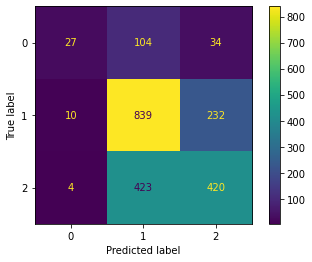

In [65]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(cv_rf_model_grid, X_test_app_processed,
                         y_test_app, 'Apple',model_name)

Confusion matrix for: Google
Model: RandomForestClassifier with Count Vectorize


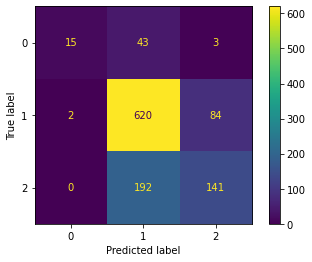

In [66]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(cv_rf_model_grid, X_test_goo_processed,
                         y_test_goo, 'Google',model_name)

In [67]:
# LogisticRegression
# Use pipes to CountVectorize X_train_combined_processed and then train LogisticRegression

start = time.time()

cv_lr_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('lr', LogisticRegression())])

cv_lr_params = {'countvect__input' : ['content'],
                'lr__random_state' : [321],
                'lr__penalty' : ['l2'],
                'lr__C' : [1.0],  # tried 1 and 1000
                'lr__class_weight' : [None],  # tried None and 'balanced'
                'lr__solver' : ['liblinear'], # tried 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'
                'lr__max_iter' : [1000]} # treid 100,1000 and 10000

cv_lr_model_grid = GridSearchCV(estimator = cv_lr_pipe, param_grid = cv_lr_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')


cv_lr_model_grid.fit(X_train_combined_processed,y_train_combined)
end = time.time()
print(f'Training time: {end-start}')
cv_lr_model_grid.best_params_


Training time: 0.8365418910980225


{'countvect__input': 'content',
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__max_iter': 1000,
 'lr__penalty': 'l2',
 'lr__random_state': 321,
 'lr__solver': 'liblinear'}

In [68]:
# Display cross validation results, make prediction for X_test_app and X_test_goo
# diplay results.  Use respective functions.

model_name = 'LogisticRegression with Count Vectorize'

display_cross_validation_results(cv_lr_model_grid.cv_results_,model_name)

y_test_app_hat7 = cv_lr_model_grid.predict(X_test_app_processed)
y_test_goo_hat7 = cv_lr_model_grid.predict(X_test_goo_processed)

display_prediction_results(y_test_app_hat7, y_test_app,'Apple',model_name)

display_prediction_results(y_test_goo_hat7, y_test_goo, 'Google',model_name)


Validation ============================================================
Validation results for LogisticRegression with Count Vectorize:
Accuracy: 0.6519049831698309
Recall: 0.6519049831698309
Precision: 0.6519049831698309

Predictions for Apple: LogisticRegression with Count Vectorize
Accuracy: 0.630673674151935
Recall: 0.630673674151935
Precision: 0.630673674151935

Predictions for Google: LogisticRegression with Count Vectorize
Accuracy: 0.7027272727272728
Recall: 0.7027272727272728
Precision: 0.7027272727272728



Confusion matrix for: Apple
Model: LogisticRegression with Count Vectorize


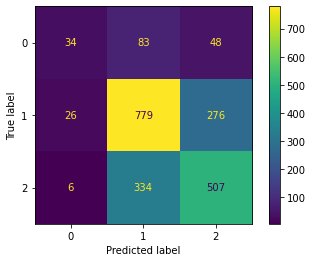

In [69]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(cv_lr_model_grid, X_test_app_processed,
                         y_test_app, 'Apple',model_name)

Confusion matrix for: Google
Model: LogisticRegression with Count Vectorize


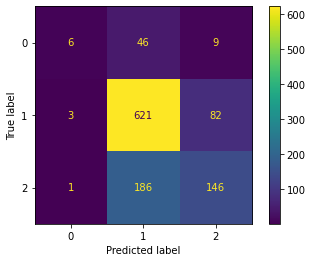

In [70]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(cv_lr_model_grid, X_test_goo_processed,
                         y_test_goo, 'Google',model_name)

In [123]:
# SVC
# Use pipes to CountVectorize X_train_combined_processed and then train SVC

start = time.time()

cv_svc_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('svc', SVC())])

cv_svc_params = {'countvect__input' : ['content'],
                'svc__random_state': [234],
                'svc__kernel' : ['rbf'], # tried 'poly','rbf', 'sigmoid'
                'svc__degree' : [3], # tried 3,4,5
                'svc__C' : [1.0],  # tried 1 and 1000
                'svc__class_weight' : [None]} # tried None and 'balanced

cv_svc_model_grid = GridSearchCV(estimator = cv_svc_pipe, param_grid = cv_svc_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')


cv_svc_model_grid.fit(X_train_combined_processed,y_train_combined)
end = time.time()
print(f'Training time: {end-start}')
cv_svc_model_grid.best_params_


Training time: 15.133240222930908


{'countvect__input': 'content',
 'svc__C': 1.0,
 'svc__class_weight': None,
 'svc__degree': 3,
 'svc__kernel': 'rbf',
 'svc__random_state': 234}

In [124]:
# Display cross validation results, make prediction for X_test_app and X_test_goo
# diplay results.  Use respective functions.

model_name = 'SVC with Count Vectorize'

display_cross_validation_results(cv_svc_model_grid.cv_results_,model_name)

y_test_app_hat8 = cv_svc_model_grid.predict(X_test_app_processed)
y_test_goo_hat8 = cv_svc_model_grid.predict(X_test_goo_processed)

display_prediction_results(y_test_app_hat8, y_test_app,'Apple',model_name)

display_prediction_results(y_test_goo_hat8, y_test_goo, 'Google',model_name)


Validation ============================================================
Validation results for SVC with Count Vectorize:
Accuracy: 0.6487671328503521
Recall: 0.6487671328503521
Precision: 0.6487671328503521

Predictions for Apple: SVC with Count Vectorize
Accuracy: 0.6316292403248925
Recall: 0.6316292403248925
Precision: 0.6316292403248925

Predictions for Google: SVC with Count Vectorize
Accuracy: 0.7127272727272728
Recall: 0.7127272727272728
Precision: 0.7127272727272728



Confusion matrix for: Apple
Model: SVC with Count Vectorize


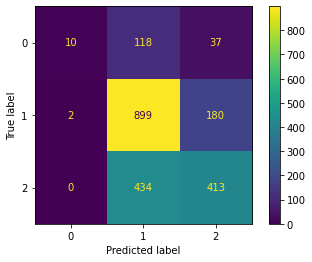

In [128]:
# Diplay confusion matrix for X_test_app
#display_confusion_matrix_v2(y_test_app,y_test_app_hat8,model_name,'Apple')
display_confusion_matrix(cv_svc_model_grid, X_test_app_processed,
                         y_test_app, 'Apple',model_name)


Confusion matrix for: Google
Model: SVC with Count Vectorize


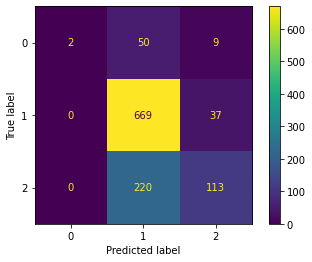

In [129]:
# Diplay confusion matrix for X_test_app
#display_confusion_matrix_v2(y_test_goo,y_test_goo_hat8,model_name,'Google')
display_confusion_matrix(cv_svc_model_grid, X_test_goo_processed,
                         y_test_goo, 'Google',model_name)

In [84]:
# Balance classification ratio with SMOTE for X_train_combined_processed

cvect = CountVectorizer()
X_train_combined_vected = cvect.fit_transform(X_train_combined_processed)

sm = SMOTE(random_state=3211)
X_train_combined_vec_sm, y_train_combined_sm = sm.fit_resample(
    X_train_combined_vected,y_train_combined)

In [78]:
# Classification ratio without SMOTE

y_train_combined.value_counts()

1    2680
2    1767
0     339
Name: sentiment, dtype: int64

In [79]:
# Classification ratio with SMOTE

y_train_combined_sm.value_counts()

2    2680
1    2680
0    2680
Name: sentiment, dtype: int64

In [80]:
# Train SVC model with SMOTED data

start = time.time()

sm_svc = SVC()

sm_svc_params = {'random_state' : [234],'kernel' : ['rbf'],'degree' : [3],'C' : [1.0],'class_weight' : [None]}

sm_svc_model_grid = GridSearchCV(estimator = sm_svc, param_grid = sm_svc_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')


sm_svc_model_grid.fit(X_train_combined_vec_sm,y_train_combined_sm)
end = time.time()
print(f'Training time: {end-start}')
sm_svc_model_grid.best_params_


Training time: 28.189348220825195


{'C': 1.0,
 'class_weight': None,
 'degree': 3,
 'kernel': 'rbf',
 'random_state': 234}

In [81]:
# Display cross validation results, make prediction for X_test_app and X_test_goo
# diplay results.  Use respective functions.

model_name = 'SVC with CountVectorizer and SMOTE'

X_test_app_vec = cvect.transform(X_test_app_processed)
X_test_goo_vec = cvect.transform(X_test_goo_processed)

display_cross_validation_results(sm_svc_model_grid.cv_results_,model_name)

y_test_app_hat9 = sm_svc_model_grid.predict(X_test_app_vec)
y_test_goo_hat9 = sm_svc_model_grid.predict(X_test_goo_vec)

display_prediction_results(y_test_app_hat9, y_test_app,'Apple',model_name)

display_prediction_results(y_test_goo_hat9, y_test_goo, 'Google',model_name)


Validation ============================================================
Validation results for SVC with CountVectorizer and SMOTE:
Accuracy: 0.6662935323383085
Recall: 0.6662935323383085
Precision: 0.6662935323383085

Predictions for Apple: SVC with CountVectorizer and SMOTE
Accuracy: 0.5862398471094123
Recall: 0.5862398471094123
Precision: 0.5862398471094123

Predictions for Google: SVC with CountVectorizer and SMOTE
Accuracy: 0.6581818181818182
Recall: 0.6581818181818182
Precision: 0.6581818181818182



Confusion matrix for: Apple
Model: SVC with CountVectorizer and SMOTE


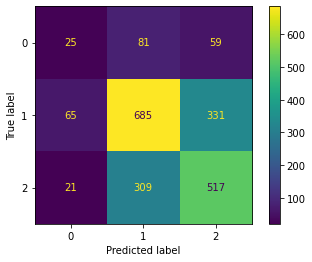

In [82]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(sm_svc_model_grid, X_test_app_vec,
                         y_test_app, 'Apple',model_name)

Confusion matrix for: Google
Model: SVC with CountVectorizer and SMOTE


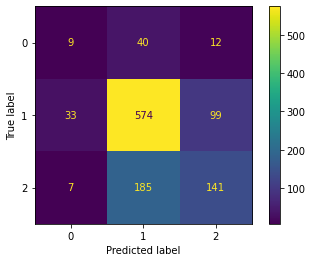

In [85]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(sm_svc_model_grid, X_test_goo_vec,
                         y_test_goo, 'Google',model_name)

In [90]:
# Process target variable into one-hot encoded using pandas get_dummies 

y_train_comb_dum = pd.get_dummies(y_train_combined).values

y_test_app_dum = pd.get_dummies(y_test_app).values
y_test_goo_dum = pd.get_dummies(y_test_goo).values

In [86]:
# Tokenize and format X_train_combined and X_test_app & X_test_goo features

tokenizer = text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(list(X_train_combined))

X_train_comb_tokens = tokenizer.texts_to_sequences(X_train_combined)
X_train_comb_tok = sequence.pad_sequences(X_train_comb_tokens, maxlen=200)

X_test_app_tokens = tokenizer.texts_to_sequences(X_test_app)
X_test_app_tok = sequence.pad_sequences(X_test_app_tokens)

X_test_goo_tokens = tokenizer.texts_to_sequences(X_test_goo)
X_test_goo_tok = sequence.pad_sequences(X_test_goo_tokens)

In [87]:
# Instaniate Sequential model and add layers

sq_model = Sequential()
embedding_size = 4
sq_model.add(Embedding(10000, embedding_size))
sq_model.add(LSTM(25, return_sequences=True))
sq_model.add(GlobalMaxPool1D())
sq_model.add(Dropout(0.6))
sq_model.add(Dense(50, activation='relu'))
sq_model.add(Dropout(0.6))
sq_model.add(Dense(3, activation='softmax'))

In [88]:
# Specify compiler parameters

sq_model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy','Recall','Precision'])

In [419]:
sq_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           40000     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 25)          3000      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 25)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                1300      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

In [91]:
# Train model with X_train_comb and y_train_comb_dum

sq_model.fit(X_train_comb_tok, y_train_comb_dum, epochs=5,
          batch_size=16, validation_split=0.1)

Epoch 1/5
270/270 [==============================] - 21s 77ms/step - loss: 0.9424 - accuracy: 0.5289 - recall: 0.2540 - precision: 0.5368 - val_loss: 0.7991 - val_accuracy: 0.6660 - val_recall: 0.6660 - val_precision: 0.6660
Epoch 2/5
270/270 [==============================] - 20s 75ms/step - loss: 0.9017 - accuracy: 0.5447 - recall: 0.3894 - precision: 0.5571 - val_loss: 0.7620 - val_accuracy: 0.6660 - val_recall: 0.6660 - val_precision: 0.6660
Epoch 3/5
270/270 [==============================] - 20s 74ms/step - loss: 0.8606 - accuracy: 0.5519 - recall: 0.4202 - precision: 0.6056 - val_loss: 0.7038 - val_accuracy: 0.6660 - val_recall: 0.6159 - val_precision: 0.7024
Epoch 4/5
270/270 [==============================] - 21s 77ms/step - loss: 0.7985 - accuracy: 0.5925 - recall: 0.4091 - precision: 0.7012 - val_loss: 0.7350 - val_accuracy: 0.6889 - val_recall: 0.5908 - val_precision: 0.7128
Epoch 5/5
270/270 [==============================] - 20s 74ms/step - loss: 0.7219 - accuracy: 0.6752

In [92]:
# Obtain model predictions for X_test_app and X_test_goo

y_test_app_pp = sq_model.predict(X_test_app_tok)
y_test_goo_pp = sq_model.predict(X_test_goo_tok)



In [93]:
# Convert probabilites to predicted sample target value 

y_test_app_hat10 = np.argmax(y_test_app_pp, axis=-1)
y_test_goo_hat10 = np.argmax(y_test_goo_pp, axis=-1)

In [94]:
# Display prediction results for X_test_app and X_test_goo

display_prediction_results(y_test_app_hat10, y_test_app,'Apple','Sequential')

display_prediction_results(y_test_goo_hat10, y_test_goo, 'Google','Sequential')

Predictions for Apple: Sequential
Accuracy: 0.5590062111801242
Recall: 0.5590062111801242
Precision: 0.5590062111801242

Predictions for Google: Sequential
Accuracy: 0.6463636363636364
Recall: 0.6463636363636364
Precision: 0.6463636363636364



## Conclusion
The base model, DummyClassifier, had a validation accuracy of about 56% on the combined apple and google tweet dataframe (train dataframe). Predictions for apple and google tweet test samples were performed separately to be able to compare the two between one another for sentiment.  The base model gave a prediction of 52% accuracy for apple and 64% for google with an overal average accuracy of 58%.  Five additioanl models (Multinomial NB, KNeighbor, Random Forest, Logistic Regression and SupportVectorClassifier(SVC))were then evaluated for their prediction performance and they all gave similar accuracy within 5% of each other.  SVC model was selected as our best model as it gave overall better performance relative to the other four. Validation accuracy for SVC model was about 65%. For test samples, accuracy for apple was about 63% and for google 71% with an overall accuracy of 67% for our best model. Utilized gridsearchcv to adjust hyperparamters(tunning) for these models. Following NLP processing the tweet text was converted into matrix of tokens using mostly CountVectorizer for TfidfVectorizer diminished model performance a little bit. To correct for data classification imbalance (7% negative, 56% neutral and 37% positive sentiment) the combined trained data was synthetically balanced using SMOTE.  However, this did not improve model performance. We also tried neural network Sequential model but were unable to increase accuracy.

Our best model for Twitter sentiment prediction was therefore SVC which gave an overal accuracy of about 67%. The model under-predicted for all three classifications relative to actual for both firms. Also, it missed predicting correctly negative sentiment the most followed by positive and then neutral.  This may be because the dataset contained the fewest mumber of negative sentiment tweets. The dataset has a moderate number of positive tweets and the most for neutral tweets. However, our model was able to correctly predict the overall trend for classification ratios where tweets with neutral sentiment had the highest ratio followed by positive and then negative. In addition, our model was able to correctly predict which of the two firms had a higher positive sentiment. 

## Next Steps:
To potentially improve models performance
* Take a closer look at tweets that had negative sentiment.  Our best model missed these more than positive and neutral sentiments
* Setup a model based on scoring words or phrases for negative, neutral or positive sentiment
* Consider data from other social media platforms like review sites for products and services